In [83]:
# NOTES
# for now, use max captured exposure as zmax, fix later
# obtain pixel value Z from camera with exposure X, exposure time dt
# want to get irradiance E, given X and dt, E = X / dt
# Z = f(X) = f(E * dt)
# invf(Z) = E * dt
# ln(invf(Z)) = ln(E) + ln(dt)
# g(a) = ln(invf(a)) --> g(Z) = ln(E) + ln(dt)
# ln(E) = g(Z) - ln(dt)
# do this for all Z_ij, E_i, dt_j (pixel i in image j)
# Goal: compute radiance of each pixel, given g, Z, dt

In [84]:
## Initialize everything

%run common.ipynb

Importing libraries...
Done!
Initialize camera and default settings...
Done!
Define functions needed to capture images...
Done!
Generating patterns for projector...
Done!


In [85]:
# global vars
global_num_buckets = 50

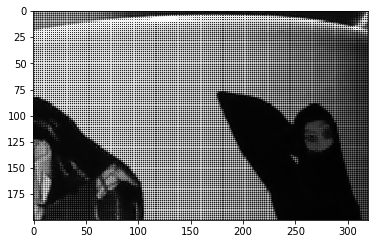

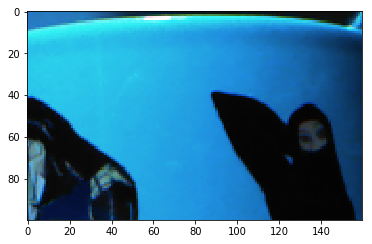

In [86]:
# show image to get camera centered
plt.imshow(get_raw_image()); plt.show();
plt.imshow(get_color_image()); plt.show();

In [87]:
# return array of imagesand array of corresponding exposures
def get_images():
    # pretend these are exposure times
    time_deltas = []
    tmin = 1
    tmax = 10
    
    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);
    
    images = []
    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    for x in numpy.linspace(tmin, tmax, global_num_buckets):
        pixy.set_exposure(x);
        img = get_raw_image();
        img = get_raw_image(); # need to call twice for exposure change to take effect
        images += [img]
        time_deltas += [x]; # x vals
        
    return [images, time_deltas]

In [88]:
#### NEW VERSION, MORE FLEXIBLE ####
def get_calibration_curve_from_images(images, time_deltas, p0=100, p1=150):
    pixel_values = []

    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    # store average pixel value for each image
    max_pixel_value = 0
    for i in range(len(images)):
        img = images[i]
        pixel_values += [numpy.mean(numpy.mean(img[p0:p1,p0:p1]))]; # y vals
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        
    print("max pixel value=" + str(max_pixel_value))
    return [pixel_values, time_deltas, max_pixel_value]


#### SO OTHER CODE DOESN'T BREAK ####
# get time --> pixel
# optional args to get calibration based on particular pixel areas of image
# returns array of pixel values and array of corresponding time values
def get_calibration_curve(p0=100, p1=150):
    [images, time_deltas] = get_images()
    return get_calibration_curve_from_images(images, time_deltas, p0, p1)

#### LOG ####
# ln(exposure time) --> pixel
def get_calibration_curve_2(p0=100, p1=150):
    pixel_values = []
    time_deltas = []

    tmin = 1
    tmax = 10

    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);

    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    # store average pixel value for each image
    max_pixel_value = 0
    num_buckets = 50
    for x in numpy.linspace(numpy.log(tmin), numpy.log(tmax), num_buckets):
        pixy.set_exposure(pow(numpy.e,x));
        val = get_raw_image();
        val = get_raw_image(); # need to call twice for exposure change to take effect
        pixel_values += [numpy.mean(numpy.mean(val[p0:p1,p0:p1]))]; # y vals
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        time_deltas += [x]; # x vals
        
    print("max pixel value=" + str(max_pixel_value))
    
    return [pixel_values, time_deltas, max_pixel_value]

#### COLOR ####
def get_color_calibrated_curve(color=0):
    # 0=red, 1=blue, 2=green
    pixel_values = []
    time_deltas = []

    tmin = 1
    tmax = 10

    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);

    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    # store average pixel value for each image
    max_pixel_value = 0
    num_buckets = 50
    for x in numpy.linspace(tmin, tmax, num_buckets):
        pixy.set_exposure(x);
        val = get_raw_image();
        val = get_raw_image(); # need to call twice for exposure change to take effect
        if color == 0: # red
            pixel_values += [numpy.mean(numpy.mean(val[1::2,1::2]))];
        elif color == 1: # green
            g1 = numpy.mean(numpy.mean(val[0::2,1::2]));
            g2 = numpy.mean(numpy.mean(val[1::2,0::2]));
            pixel_values += [numpy.mean([g1,g2])]
        else: # blue
            pixel_values += [numpy.mean(numpy.mean(val[0::2,0::2]))];
#         A = image[0::2,0::2]; blue
#         B = image[0::2,1::2]; green
#         C = image[1::2,0::2]; green
#         D = image[1::2,1::2]; red
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        time_deltas += [x]; # x vals
        
    print("max pixel value=" + str(max_pixel_value))
    
    return [pixel_values, time_deltas, max_pixel_value]

In [99]:
# get pixel --> time
# returns array with exposures corresponding to pixel values
# max and min pixel values optional inputs zmin, zmax
def generate_response_curve(pixel_values, time_deltas, zmin=0, zmax=255):
    def get_bucket(px):
        frac = (px - zmin) / (zmax+1)
        return int(frac * global_num_buckets)

    # use numpy.interp instead?
    def lin_interp(x, x0, x1, y0, y1):
        z = (x-x0)/(x1-x0)
        #print(str(x) + " x0=" + str(x0) + " x1="+ str(x1) + " y0="+ str(y0) + " y1="+ str(y1) + " ")
        return y0*(z) + y1*(1-z)

    # given pixel value x, returns exposure time
    def g(x):
        m = get_bucket(x)
        if m+1 == num_buckets:
            #print("endglobal_num_buckets
            return time_deltas[-1]
        x0 = pixel_values[m]
        x1 = pixel_values[m+1]
        y0 = time_deltas[m]
        y1 = time_deltas[m+1]
        if (x0 >= x1 or y0 > y1):
            #print("bad vals")
            return None
        return lin_interp(x, x0, x1, y0, y1)

    # plot exposure time as function of pixel value
    deltas = []
    print("lengths:" + str(len(pixel_values)) + "," + str(len(time_deltas)))
    thresh = 100
    for z in numpy.linspace(zmin, zmax, global_num_buckets):
        x = g(z)
        if (x != None and x < thresh):
            deltas += [x]
    #print("exposure vs pixel value")
    #plt.plot(deltas); plt.show();
    
    return deltas

#generate_response_curve(pixel_values, time_deltas)

In [100]:
# response curve ln
# return modified exposure array
def ln_response_curve(exposures):
    lnE = 50
    for i in range(len(exposures)):
        exposures[i] = numpy.log(exposures[i] + lnE)
    #print("ln(exposure) vs pixel value(Zij)")
    #plt.plot(exposures); plt.show();
    return exposures

max pixel value=15.444625
max pixel value=57.6105
max pixel value=112.0943125


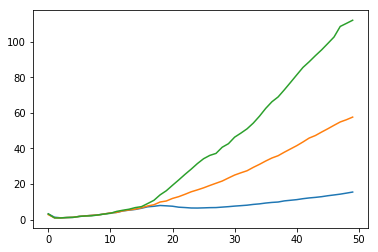

In [101]:
# color calibration curve
[pv0, td0, mpv0] = get_color_calibrated_curve(0)
[pv1, td1, mpv1] = get_color_calibrated_curve(1)
[pv2, td2, mpv2] = get_color_calibrated_curve(2)
plt.plot(pv0); 
plt.plot(pv1); 
plt.plot(pv2); 
plt.show();

max pixel value=108.5228
pixel_value vs ln(exposure time)


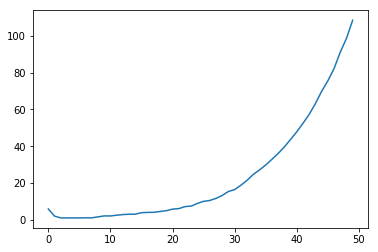

In [102]:
# plot ln
[bleh0, bleh1, bleh2] = get_calibration_curve_2(50,100)
print("pixel_value vs ln(exposure time)")
plt.plot(bleh0); plt.show();

max pixel value=65.6309761976
pixel_value vs exposure


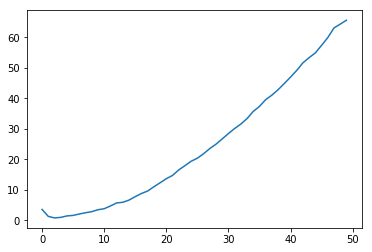

lengths:50,50
exposure vs pixel value


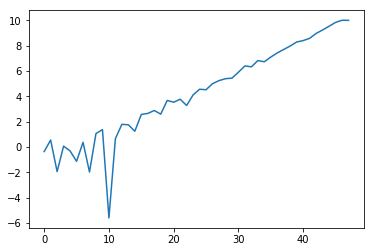

ln(exposure) vs pixel value(Zij)


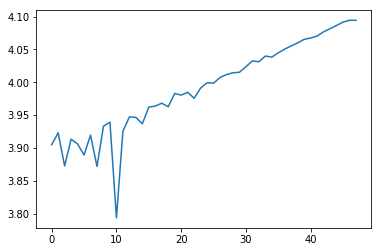

In [103]:
#calibration curve
[pixel_values, time_deltas, max_pixel_value] = get_calibration_curve(0,-1)
print("pixel_value vs exposure"); 
plt.plot(pixel_values); 
plt.show();

#response curve
exposures = generate_response_curve(pixel_values, time_deltas, 0, max_pixel_value)
print("exposure vs pixel value"); 
plt.plot(exposures); 
plt.show();

# log
lnexposures = ln_response_curve(exposures)
print("ln(exposure) vs pixel value(Zij)"); 
plt.plot(lnexposures); 
plt.show();

In [104]:
# weight function
def make_w(zmin, zmax):
    def w(z):
        if (z < 0.5*(zmin + zmax)):
            return z - zmin
        else:
            return zmax - z
    return w

# pixel i in image j
def Z(i,j):
    return images[j][i]

In [160]:
# Given g, Z_ij, dt_j, return ln(E_i)
# Given set of images, set of exposure times, pixel index --> return radiance of pixel @ row r, column c
def get_radiance(images, exposure_times, r, c):
    w = make_w(0, 60)
    weighted_exposures = 0
    weights_sum = 0
    height = len(images[0])
    width = len(images[0][0])
    
    for j in range(0, len(images)):
        dt = exposure_times[j]
        img = images[j]
#         z = img[i % width][i / width]
        z = img[r][c]
        weighted_exposures += w(z)*(g(z) - numpy.log(dt))
        weights_sum += w(z)
        
    lnE = weighted_exposures / weights_sum
    return pow(numpy.e, lnE)

def make_g(pixel_values, exposure_times, num_buckets, zmin, zmax):
    print("num buckets=" + str(num_buckets) + ", zmax=" + str(zmax))
    def get_bucket(px):
        frac = (px - zmin) / (zmax+1)
        return int(frac * num_buckets)

    # use numpy.interp instead?
    def lin_interp(x, x0, x1, y0, y1):
        z = (x-x0)/(x1-x0)
        #print(str(x) + " x0=" + str(x0) + " x1="+ str(x1) + " y0="+ str(y0) + " y1="+ str(y1) + " ")
        return y0*(z) + y1*(1-z)
    
    # given pixel value x, returns exposure time
    def g(x):
        m = get_bucket(x)
#         print(m)
        if m+1 >= num_buckets: 
            return exposure_times[-1]
        x0 = pixel_values[m]
        x1 = pixel_values[m+1]
        y0 = exposure_times[m]
        y1 = exposure_times[m+1]
        if (x0 >= x1 or y0 > y1):
            #print("bad vals")
            return 0
        return lin_interp(x, x0, x1, y0, y1)
    
    return g

max pixel value=64.2855500071
pixel_value vs exposure


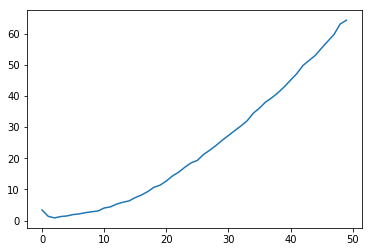

In [110]:
# ALL TOGETHER
[images, exposure_times] = get_images()

#calibration curve
[pixel_values, exposure_times, max_pixel_value] = get_calibration_curve_from_images(images, exposure_times, 0,-1)
print("pixel_value vs exposure"); 
plt.plot(pixel_values); 
plt.show();

In [ ]:
g = make_g(pixel_values, exposure_times, global_num_buckets, 0, max_pixel_value)

# construct hdr image
new_image = []
image_size = len(images[0])

height = len(images[0])
width = len(images[0][0])

for r in range(height):
    row = []
    for c in range(width):
        # for each pixel
        row += [get_radiance(images, exposure_times, r, c)]
    new_image += [row]

print(len(images[0]))
print(len(new_image))
print(images[0])
plt.imshow(images[0]); plt.show();
plt.imshow(new_image); plt.show();